In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import cv2
from skimage import color
from skimage import io
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy
import random
import csv as csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


Instructions for updating:
Colocations handled automatically by placer.


# Train a dog-cat classifier

In [2]:
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test/'

IMG_SIZE = 50
def read_image(file_path):        
    img= cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img= cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    return img

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
        if i%5000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train_cats = sorted(glob.glob(os.path.join(TRAIN_DIR, 'cat*.jpg')))
train_dogs = sorted(glob.glob(os.path.join(TRAIN_DIR, 'dog*.jpg')))
train_all = train_dogs+train_cats 

random.Random(4).shuffle(train_all)

test_all = sorted(glob.glob(os.path.join(TEST_DIR, '*.jpg')))

X_train = prep_data([path for path in train_all])
Y_train = np.array([[1., 0.] if 'dog' in name else [0., 1.] for name in train_all])

X_test = prep_data([path for path in test_all])
Y_test = np.array([[1., 0.] if 'dog' in name else [0., 1.] for name in test_all])

Processed 0 of 25000
Processed 5000 of 25000
Processed 10000 of 25000
Processed 15000 of 25000
Processed 20000 of 25000
Processed 0 of 12500
Processed 5000 of 12500
Processed 10000 of 12500


In [3]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')
model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=500, show_metric=True, run_id='dog-cat')

Training Step: 1172  | total loss: 0.51295 | time: 56.659s
| Adam | epoch: 003 | loss: 0.51295 - acc: 0.7462 -- iter: 24960/25000
Training Step: 1173  | total loss: 0.50972 | time: 65.305s
| Adam | epoch: 003 | loss: 0.50972 - acc: 0.7513 | val_loss: 0.80154 - val_acc: 0.5116 -- iter: 25000/25000
--


# Run inference

In [55]:
def pyramid(image, scale=1.5, minSize=(50, 50)):
    # yield the original image
    yield image
    
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image
        
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def get_grey_and_color_image(path):
    return cv2.imread(path), cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
def run_inference(image):
    (w, h) = (50, 50)
    # loop over the image pyramid
    scale = 1.
    cats_score = []
    cats_bbox = []
    dogs_score = []
    dogs_bbox = []
    for resized in pyramid(image, scale=1.5):
        # loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(w, h)):
            input_data = np.ndarray((1, IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)
            input_data[0] = window.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
            out = model.predict(input_data)[0]

            if np.argmax(out) == 1:
                if out[1] > 0.8:
                    cats_score.append(out[1])
                    cats_bbox.append((int(x * scale), int(y * scale), int(w * scale), int(h * scale)))
            else:
                if out[0] > 0.8:
                    dogs_score.append(out[0])
                    dogs_bbox.append((int(x * scale), int(y * scale), int(w * scale), int(h * scale)))

        scale = scale * 1.5
    return cats_score, cats_bbox, dogs_score, dogs_bbox

In [56]:
def showWindows(image, dogs_bbox, cats_bbox):
    for (x, y, w, h) in dogs_bbox:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    for (x, y, w, h) in cats_bbox:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(np.array(image).astype('uint8'))
    plt.show()
    
THRESHOLD = 0.3
def nms(scores, bboxes):
    sortedRes = sorted(zip(scores, bboxes), key=lambda x: x[0], reverse=True)
    scores = [score for (score, bbox) in sortedRes]
    bboxes = [bbox for (score, bbox) in sortedRes]
    
    suppress = [0] * len(scores)
    result = []
    for i in range(len(bboxes)):
        if suppress[i] == 1:
            continue
        
        area = bboxes[i][2] * bboxes[i][3]
        result.append(bboxes[i])
        for j in range(i+1, len(bboxes)):
            if suppress[j] == 1:
                continue
            
            otherArea = bboxes[j][2] * bboxes[j][3]
            
            xx1 = np.maximum(bboxes[i][0], bboxes[j][0])
            yy1 = np.maximum(bboxes[i][1], bboxes[j][1])
            xx2 = np.minimum(bboxes[i][0] + bboxes[i][2] - 1, bboxes[j][0] + bboxes[j][2] - 1)
            yy2 = np.minimum(bboxes[i][1] + bboxes[i][3] - 1, bboxes[j][1] + bboxes[j][3] - 1)
            
            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / min(area, otherArea)
            if ovr > THRESHOLD:
                suppress[j] = 1
    return result

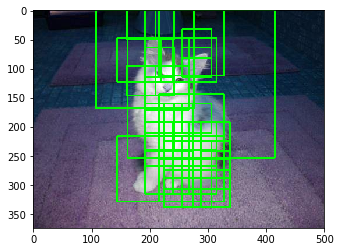

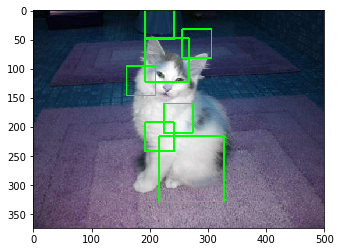

In [57]:
color_image, image = get_grey_and_color_image(test_all[1])

cats_score, cats_bbox, dogs_score, dogs_bbox = run_inference(image)
showWindows(color_image.copy(), dogs_bbox, cats_bbox)

new_dogs_bboxes = nms(dogs_score, dogs_bbox)
new_cats_bboxes = nms(cats_score, cats_bbox)
showWindows(color_image.copy(), new_dogs_bboxes, new_cats_bboxes)

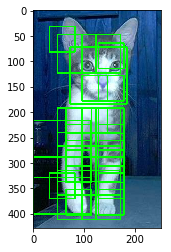

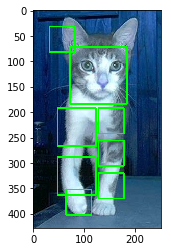

In [65]:
color_image, image = get_grey_and_color_image(test_all[2010])

cats_score, cats_bbox, dogs_score, dogs_bbox = run_inference(image)
showWindows(color_image.copy(), dogs_bbox, cats_bbox)

new_dogs_bboxes = nms(dogs_score, dogs_bbox)
new_cats_bboxes = nms(cats_score, cats_bbox)
showWindows(color_image.copy(), new_dogs_bboxes, new_cats_bboxes)